# **Urban features as determinants of road safety**

This notebook was developed for the regression task of the paper "*Identifying urban features for vulnerable road user safety in Europe*".

Last update: 2021-04-14 <br>
Contact: mrnkln@outlook.com, (Marina Klanjčić)<br>

---

#### **Input variables** (standardized):
* city density
* cycling area share
* speed limited area share
* walking mode share
* cycling mode share
* motor vehicles mode share
* public transport mode share

#### **Output variables** (normalized by population and standardized):
* Pedestrian - Car/Taxi
* Cyclist - Car/Taxi
* PTW occupant - Car/Taxi
* PTW occupant - Itself
* Car/Taxi occupant - Car/Taxi
* Car/Taxi occupant - Itself

#### **Imports:**

In [1]:
# importing all the libraries

import pandas as pd  
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt  
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import timeit
import warnings

warnings.filterwarnings("ignore")
afont = {'fontname':'Arial'}
%matplotlib inline

#### **Functions used:**

In [2]:
# function for using statsmodels OLS and scikit-learn's cross-validation
 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.estimator_checks import check_estimator

class linear_regression(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True):

        self.fit_intercept = fit_intercept

    """
    Parameters
    ------------
    column_names: list
            It is an optional value, such that this class knows 
            what is the name of the feature to associate to 
            each column of X. This is useful if you use the method
            summary(), so that it can show the feature name for each
            coefficient
    """ 
    def fit(self, X, y, column_names=() ):

        if self.fit_intercept:
            X = sm.add_constant(X)

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y

        if len(column_names) != 0:
            cols = column_names.copy()
            cols = list(cols)
            X = pd.DataFrame(X)
            cols = column_names.copy()
            cols.insert(0,'Intercept')
            #print('X ', X)
            X.columns = cols

        self.model_ = sm.OLS(y, X)
        self.results_ = self.model_.fit()
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, 'model_')

        # Input validation
        X = check_array(X)

        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

    def get_params(self, deep = False):
        return {'fit_intercept':self.fit_intercept}

    def summary(self):
        print(self.results_.summary() )

In [3]:
# function that plots model coefficient weights as alpha grows

def weight_versus_alpha_plot(weight, alphas, features, title):
    """
    Pass in the estimated weight, the alpha value and the names
    for the features and plot the model's estimated coefficient weight 
    for different alpha values
    """
    fig = plt.figure(figsize = (7, 5))
    
    # ensure that the weight is an array
    weight = np.array(weight)
    for col in range(weight.shape[1]):
        plt.plot(alphas, weight[:, col], label = features[col])

    plt.axhline(0, color = 'black', linestyle = '--', linewidth = 3)
    
    fig.tight_layout()
    plt.legend(loc='best')
    plt.xscale('log')
    plt.title(title, fontweight= 'bold', fontsize= 13)
    plt.ylabel('Coefficient weight')
    plt.xlabel('Alpha value')
    return fig

In [4]:
# function for the casualty prediction with K-fold cross-validation

def prediction(X, y, folds, random_state = None, shuffle = False):
    kf = KFold(n_splits=folds, random_state = random_state, shuffle = shuffle)
    i = 0
    r2_train = []
    r2_test = []
    rmse_train = []
    rmse_test = []
    predictions = []
    model = linear_regression()
    
    for train_index, test_index in kf.split(X):
        i = i+1;
        print("============================ FOLD NUMBER %i ===================================" % i)
        print("TRAIN:", train_index)
        print("TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print('------------------------------------------------------------------------------')
        
        model.fit(X_train, y_train, column_names= cols)
        model.summary()
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        predictions.append(y_test_pred)
        
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))
        
        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        print('\n')
        
    flatten = lambda l: [item for sublist in l for item in sublist]
    predictions = flatten(predictions)
    
    score = [rmse_train, rmse_test, r2_train, r2_test]
    mean = pd.DataFrame([np.mean(rmse_train), np.mean(rmse_test), np.mean(r2_train), np.mean(r2_test)]).rename(columns={0: "MEAN"})
    scores = pd.DataFrame(score).rename(index={0: "RMSE_train", 1: "RMSE_test", 2: "R2_train", 3: "R2_test"}, 
                                        columns={0: "Fold #1", 1: "Fold #2", 2: "Fold #3"})
    scores["MEAN"] = mean.values
    return {'scores': scores, 'predictions': predictions}

#### **Parameters:**

In [5]:
# defining alpha range

l_min = -1
l_max = 0
l_num = 1000
alphas = np.logspace(l_min, l_max, l_num)
params = {'alpha': alphas}

#### **Data import:** *(adjustment needed for reproduction)*

In [6]:
# loading the data from GitHub
# IMPORTANT: adjust the path once you download the data locally

path = "/Users/Otkup/GitHub/urbanroadsafety/data/"
file = path + "urban_road_safety_data.csv"

data = pd.read_csv(file)
data

,Country Code,Country,City Code,City,Population,Density (pop./ sq km),Cycling area share,Speed limit area share,Mode - walking (%),Mode - cycling (%),...,Goods Vehicle occ. - Bus/Coach,Goods Vehicle occ. - Goods Vehicle,Goods Vehicle occ. - Other Vehicles,Other Vehicles occ. - Itself,Other Vehicles occ. - Bicycle,Other Vehicles occ. - PTW,Other Vehicles occ. - Car/Taxi,Other Vehicles occ. - Bus/Coach,Other Vehicles occ. - Goods Vehicle,Other Vehicles occ. - Other Vehicles
0,ES,Spain,08019,Barcelona,1620343,16014,0.150,0.775,32.0,2.00,...,0,0,0,0,0,0,2,1,0,0
1,ES,Spain,28079,Madrid,3223334,5332,0.067,0.065,34.0,0.46,...,0,1,0,0,0,0,4,0,1,0
2,FR,France,33063,Bordeaux,254436,5104,0.106,0.239,21.0,3.00,...,0,0,0,0,0,0,1,0,0,0
3,FR,France,59350,Lille,232787,6687,0.098,0.634,32.0,2.00,...,0,0,0,0,0,0,0,0,0,0
4,FR,France,69123,Lyon,516092,10758,0.109,0.284,34.0,2.00,...,0,0,0,1,0,0,4,0,0,1
5,FR,France,13055,Marseille,863310,3564,0.044,0.118,34.0,1.00,...,0,0,0,0,0,0,3,1,0,0
6,FR,France,34172,Montpellier,285121,4997,0.167,0.125,26.0,2.00,...,0,0,0,0,0,0,1,0,0,0
7,FR,France,44109,Nantes,309346,4704,0.327,0.354,27.0,5.00,...,0,0,0,0,0,0,0,0,0,0
8,FR,France,06088,Nice,340017,4586,0.056,0.102,40.0,1.00,...,0,0,0,0,0,0,0,0,0,0
9,FR,France,75056,Paris,2187526,20772,0.186,0.491,47.0,3.00,...,0,0,0,1,1,0,4,1,0,0


In [7]:
# observing only the pairs with median values > 5

data_describe = data.iloc[:, 12:].describe()
index = np.where((data_describe.iloc[5] < 5)==True)
index = pd.DataFrame(index)
data_describe.drop(data_describe.columns[index.iloc[0]], axis=1, inplace=True)
data_describe

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Itself,PTW occ. - Car/Taxi,Car/Taxi occ. - Itself,Car/Taxi occ. - Car/Taxi
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,70.708333,30.458333,21.958333,74.833333,18.041667,40.166667
std,93.082235,67.586324,35.533792,106.463166,28.545127,53.327264
min,5.000000,1.000000,1.000000,2.000000,0.000000,1.000000
25%,18.250000,5.750000,3.500000,15.500000,4.750000,6.000000
50%,36.500000,14.000000,6.000000,29.500000,7.500000,17.500000
75%,67.250000,27.250000,20.000000,65.250000,21.000000,49.250000
max,398.000000,340.000000,143.000000,371.000000,138.000000,217.000000


In [8]:
# keeping only the KSI pairs we are observing

data = data[['Country Code', 'Country', 'City Code', 'City', 'Population',
             'Density (pop./ sq km)', 'Cycling area share', 'Speed limit area share',
             'Mode - walking (%)', 'Mode - cycling (%)', 'Mode - public transport (%)', 'Mode - motor vehicles (%)',
             'Pedestrian - Car/Taxi', 'Cyclist - Car/Taxi',
             'PTW occ. - Car/Taxi', 'PTW occ. - Itself', 
             'Car/Taxi occ. - Car/Taxi', 'Car/Taxi occ. - Itself']]
data

,Country Code,Country,City Code,City,Population,Density (pop./ sq km),Cycling area share,Speed limit area share,Mode - walking (%),Mode - cycling (%),Mode - public transport (%),Mode - motor vehicles (%),Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
0,ES,Spain,08019,Barcelona,1620343,16014,0.150,0.775,32.0,2.00,39.00,27.00,22,5,96,29,4,0
1,ES,Spain,28079,Madrid,3223334,5332,0.067,0.065,34.0,0.46,24.35,39.89,201,18,275,95,72,44
2,FR,France,33063,Bordeaux,254436,5104,0.106,0.239,21.0,3.00,9.00,67.00,13,5,14,2,1,3
3,FR,France,59350,Lille,232787,6687,0.098,0.634,32.0,2.00,10.00,56.00,5,1,7,2,6,2
4,FR,France,69123,Lyon,516092,10758,0.109,0.284,34.0,2.00,19.00,45.00,31,11,39,12,21,8
5,FR,France,13055,Marseille,863310,3564,0.044,0.118,34.0,1.00,11.00,54.00,56,9,146,45,48,30
6,FR,France,34172,Montpellier,285121,4997,0.167,0.125,26.0,2.00,8.00,64.00,21,4,21,8,12,9
7,FR,France,44109,Nantes,309346,4704,0.327,0.354,27.0,5.00,16.00,52.00,13,7,13,6,6,1
8,FR,France,06088,Nice,340017,4586,0.056,0.102,40.0,1.00,11.00,48.00,20,2,50,6,6,5
9,FR,France,75056,Paris,2187526,20772,0.186,0.491,47.0,3.00,33.00,17.00,58,14,132,48,24,12


In [9]:
# normalizing the target variables by population (per 1 million inhabitants) & removing the population column afterwards

data = data.copy()
data.iloc[:, 12:] = ((data.iloc[:, 12:].div(data.iloc[:, 4], axis=0))*1000000).round(2)
data.drop(['Population'], axis=1, inplace=True)
data

,Country Code,Country,City Code,City,Density (pop./ sq km),Cycling area share,Speed limit area share,Mode - walking (%),Mode - cycling (%),Mode - public transport (%),Mode - motor vehicles (%),Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
0,ES,Spain,08019,Barcelona,16014,0.150,0.775,32.0,2.00,39.00,27.00,13.58,3.09,59.25,17.90,2.47,0.00
1,ES,Spain,28079,Madrid,5332,0.067,0.065,34.0,0.46,24.35,39.89,62.36,5.58,85.32,29.47,22.34,13.65
2,FR,France,33063,Bordeaux,5104,0.106,0.239,21.0,3.00,9.00,67.00,51.09,19.65,55.02,7.86,3.93,11.79
3,FR,France,59350,Lille,6687,0.098,0.634,32.0,2.00,10.00,56.00,21.48,4.30,30.07,8.59,25.77,8.59
4,FR,France,69123,Lyon,10758,0.109,0.284,34.0,2.00,19.00,45.00,60.07,21.31,75.57,23.25,40.69,15.50
5,FR,France,13055,Marseille,3564,0.044,0.118,34.0,1.00,11.00,54.00,64.87,10.42,169.12,52.12,55.60,34.75
6,FR,France,34172,Montpellier,4997,0.167,0.125,26.0,2.00,8.00,64.00,73.65,14.03,73.65,28.06,42.09,31.57
7,FR,France,44109,Nantes,4704,0.327,0.354,27.0,5.00,16.00,52.00,42.02,22.63,42.02,19.40,19.40,3.23
8,FR,France,06088,Nice,4586,0.056,0.102,40.0,1.00,11.00,48.00,58.82,5.88,147.05,17.65,17.65,14.71
9,FR,France,75056,Paris,20772,0.186,0.491,47.0,3.00,33.00,17.00,26.51,6.40,60.34,21.94,10.97,5.49


In [10]:
# standardizing the input variables (urban features)

scalerx = StandardScaler(with_std=True)
data.iloc[:, 4:11]  = scalerx.fit_transform(data.iloc[:, 4:11])
data

,Country Code,Country,City Code,City,Density (pop./ sq km),Cycling area share,Speed limit area share,Mode - walking (%),Mode - cycling (%),Mode - public transport (%),Mode - motor vehicles (%),Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
0,ES,Spain,08019,Barcelona,2.276505,0.412738,1.939291,0.675789,-0.284028,1.700269,-1.786851,13.58,3.09,59.25,17.90,2.47,0.00
1,ES,Spain,28079,Madrid,-0.032642,-0.617555,-0.943759,0.844385,-0.823476,0.248382,-0.842557,62.36,5.58,85.32,29.47,22.34,13.65
2,FR,France,33063,Bordeaux,-0.081929,-0.133442,-0.237209,-0.251489,0.066263,-1.272879,1.143464,51.09,19.65,55.02,7.86,3.93,11.79
3,FR,France,59350,Lille,0.260271,-0.232747,1.366742,0.675789,-0.284028,-1.173774,0.337627,21.48,4.30,30.07,8.59,25.77,8.59
4,FR,France,69123,Lyon,1.140306,-0.096202,-0.054480,0.844385,-0.284028,-0.281830,-0.468209,60.07,21.31,75.57,23.25,40.69,15.50
5,FR,France,13055,Marseille,-0.414834,-0.903058,-0.728545,0.844385,-0.634319,-1.074669,0.191111,64.87,10.42,169.12,52.12,55.60,34.75
6,FR,France,34172,Montpellier,-0.105059,0.623762,-0.700121,0.170001,-0.284028,-1.371984,0.923690,73.65,14.03,73.65,28.06,42.09,31.57
7,FR,France,44109,Nantes,-0.168398,2.609868,0.229764,0.254299,0.766846,-0.579145,0.044596,42.02,22.63,42.02,19.40,19.40,3.23
8,FR,France,06088,Nice,-0.193906,-0.754100,-0.793516,1.350173,-0.634319,-1.074669,-0.248436,58.82,5.88,147.05,17.65,17.65,14.71
9,FR,France,75056,Paris,3.305050,0.859612,0.786071,1.940259,0.066263,1.105640,-2.519430,26.51,6.40,60.34,21.94,10.97,5.49


In [11]:
# checking the mean and std values after standardization

print("Mean:\n", data.mean(axis=0))
print("\nSTD:\n", data.std(axis=0))

Mean:
 Density (pop./ sq km)          0.000000e+00
Cycling area share            -7.401487e-17
Speed limit area share         3.700743e-17
Mode - walking (%)            -7.401487e-17
Mode - cycling (%)            -3.700743e-17
Mode - public transport (%)   -1.850372e-17
Mode - motor vehicles (%)      5.181041e-16
Pedestrian - Car/Taxi          6.722083e+01
Cyclist - Car/Taxi             2.920042e+01
PTW occ. - Car/Taxi            6.226292e+01
PTW occ. - Itself              1.653625e+01
Car/Taxi occ. - Car/Taxi       4.091500e+01
Car/Taxi occ. - Itself         1.766458e+01
dtype: float64

STD:
 Density (pop./ sq km)           1.021508
Cycling area share              1.021508
Speed limit area share          1.021508
Mode - walking (%)              1.021508
Mode - cycling (%)              1.021508
Mode - public transport (%)     1.021508
Mode - motor vehicles (%)       1.021508
Pedestrian - Car/Taxi          38.108230
Cyclist - Car/Taxi             25.760882
PTW occ. - Car/Taxi           

In [12]:
# preparing the results dataframe

res = pd.DataFrame(columns = data.iloc[:, 11:].columns.tolist(), index = data.iloc[:, 4:11].columns.tolist())
res

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
Density (pop./ sq km),NaN,NaN,NaN,NaN,NaN,NaN
Cycling area share,NaN,NaN,NaN,NaN,NaN,NaN
Speed limit area share,NaN,NaN,NaN,NaN,NaN,NaN
Mode - walking (%),NaN,NaN,NaN,NaN,NaN,NaN
Mode - cycling (%),NaN,NaN,NaN,NaN,NaN,NaN
Mode - public transport (%),NaN,NaN,NaN,NaN,NaN,NaN
Mode - motor vehicles (%),NaN,NaN,NaN,NaN,NaN,NaN


---
# **Regression task for each of the 6 target variables:**

---

### Variable selection for Pedestrian - Car/Taxi casualties

In [13]:
# standardizing the target variable

scalery = StandardScaler(with_std=True)
data.iloc[:, 11] = scalery.fit_transform(data.iloc[:, 11].to_numpy().reshape(-1,1))

In [14]:
# selecting the input/output variables for the prediction task

target_col = "Pedestrian - Car/Taxi"
X_columns = data.iloc[:, 4:11].columns
X = data.iloc[:, 4:11]
y = data.iloc[:, 11]

[Text(0.5, 0, 'Pedestrian - Car/Taxi'),
 Text(1.5, 0, 'Mode - motor vehicles (%)'),
 Text(2.5, 0, 'Mode - public transport (%)'),
 Text(3.5, 0, 'Speed limit area share'),
 Text(4.5, 0, 'Density (pop./ sq km)'),
 Text(5.5, 0, 'Mode - cycling (%)'),
 Text(6.5, 0, 'Cycling area share'),
 Text(7.5, 0, 'Mode - walking (%)')]

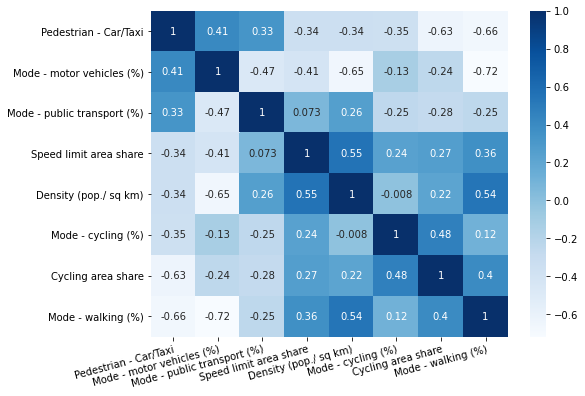

In [15]:
# showing the correlation heatmap

k = 11
columns = data.iloc[:, :12].corr().nlargest(k, target_col)[target_col].index
cm = data[columns].corr()
plt.figure(figsize= (8,6))
hmap = sns.heatmap(cm, xticklabels= True, annot=True, cmap= 'Blues')
hmap.set_xticklabels(labels = hmap.get_xticklabels(), rotation= 15, ha="right", rotation_mode="anchor")

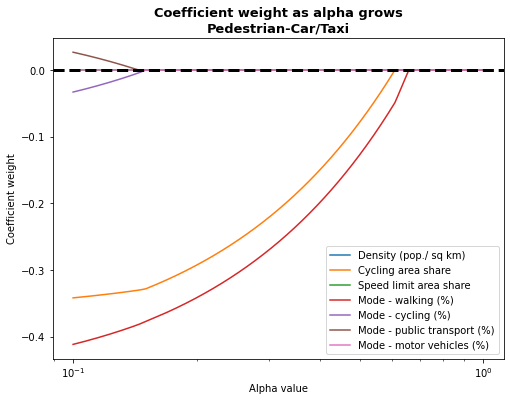

In [16]:
# showing the coefficient evolution as alpha changes

coefs = []
for alpha in alphas:    
    lasso = Lasso(alpha = alpha, fit_intercept = True, max_iter = 10000)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
lasso_fig = weight_versus_alpha_plot(coefs, alphas, data.columns[4:11],
                                     'Coefficient weight as alpha grows\nPedestrian-Car/Taxi')

In [17]:
# searching for the best estimator

kf = KFold(n_splits=3, shuffle = False)
lasso_regressor = GridSearchCV(Lasso(), params, scoring = 'neg_mean_squared_error', cv=kf)

lasso_regressor.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Lasso(),
             param_grid={'alpha': array([0.1       , 0.10023075, 0.10046204, 0.10069386, 0.10092622,
       0.10115911, 0.10139254, 0.10162651, 0.10186102, 0.10209607,
       0.10233166, 0.10256779, 0.10280447, 0.1030417 , 0.10327947,
       0.1035178 , 0.10375667, 0.10399609, 0.10423607, 0.1044766 ,
       0.10471768, 0.10495932, 0.10520...
       0.93534315, 0.9375015 , 0.93966483, 0.94183315, 0.94400648,
       0.94618482, 0.94836819, 0.95055659, 0.95275005, 0.95494856,
       0.95715215, 0.95936083, 0.9615746 , 0.96379348, 0.96601748,
       0.96824661, 0.97048089, 0.97272032, 0.97496492, 0.9772147 ,
       0.97946967, 0.98172984, 0.98399523, 0.98626585, 0.9885417 ,
       0.99082281, 0.99310918, 0.99540083, 0.99769776, 1.        ])},
             scoring='neg_mean_squared_error')

In [18]:
# best estimator

print('Mean with best score: ', lasso_regressor.best_score_)
print('Best estimator: ', lasso_regressor.best_estimator_)

lasso_best = lasso_regressor.best_estimator_
lasso_best.fit(X,y)

Mean with best score:  -0.5963549408948368
Best estimator:  Lasso(alpha=0.1)


Lasso(alpha=0.1)

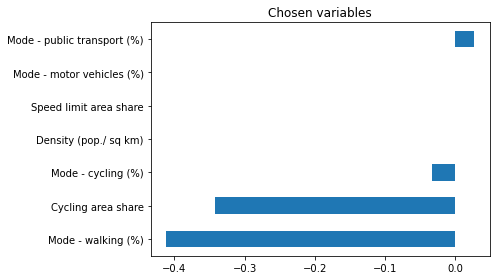

In [19]:
# showing the variables chosen by the best estimator

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (7, 4))
coef.plot(kind='barh', title = 'Chosen variables')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

In [20]:
# identifying chosen urban features

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef = coef.to_frame().reset_index().rename(columns={0: 'Value', 'index': 'Coefficient'})
coef_in = (coef.Value != 0)
coef_list = (coef_in.index[coef_in] + 4).tolist()

In [21]:
# setting the input/output variables for the prediction

cols = data.iloc[:, coef_list].columns.tolist()
X = data.iloc[:, coef_list].values
y = y.values

In [22]:
# prediction with the selected variables and 3-fold cross-validation

results = prediction(X, y, folds=3)

============================ FOLD NUMBER 1 ===================================
TRAIN: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
TEST: [0 1 2 3 4 5 6 7]
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     6.183
Date:                Wed, 14 Apr 2021   Prob (F-statistic):            0.00737
Time:                        00:01:43   Log-Likelihood:                -14.528
No. Observations:                  16   AIC:                             39.06
Df Residuals:                      11   BIC:                             42.92
Df Model:                           4                                         
Covariance Type:            nonrobust             

### Final OLS regression for Pedestrian - Car/Taxi casualties

In [23]:
# final model with selected variables

X = data.iloc[:, coef_list]
y = data.iloc[:, 11]

In [24]:
# final OLS regression

X = sm.add_constant(X)
final = sm.OLS(y, X).fit()
p = final.params
print(final.summary())

print('\n')
print('R2: ', final.rsquared)
print('Predicted values: ', final.predict())

                              OLS Regression Results                             
Dep. Variable:     Pedestrian - Car/Taxi   R-squared:                       0.610
Model:                               OLS   Adj. R-squared:                  0.527
Method:                    Least Squares   F-statistic:                     7.418
Date:                   Wed, 14 Apr 2021   Prob (F-statistic):           0.000893
Time:                           00:01:43   Log-Likelihood:                -22.766
No. Observations:                     24   AIC:                             55.53
Df Residuals:                         19   BIC:                             61.42
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [25]:
# inverse transformation of the data

y_pred_inversed = scalery.inverse_transform(final.fittedvalues)
y_pred_inversed

array([ 56.03780215,  64.41595592,  69.17232492,  55.56763449,
        53.57679276,  63.35062242,  52.20816781,  22.19611038,
        52.27137996,  24.11197363,   7.02372277,  51.28926985,
        95.35806529, 115.83853766,  57.21498832,  51.87364466,
        77.05006183, 110.22836715, 101.90198895,  71.49138044,
        93.67394206, 105.35655734, 116.27647643,  45.81423283])

In [26]:
# inverse transformation of the data

y_inversed = scalery.inverse_transform(y)
y_inversed

array([ 13.58,  62.36,  51.09,  21.48,  60.07,  64.87,  73.65,  42.02,
        58.82,  26.51,  17.8 ,  25.02, 134.05, 111.7 ,  53.95,  63.65,
        97.38,  95.03, 143.49, 110.55,  73.04, 113.3 ,  86.68,  13.21])

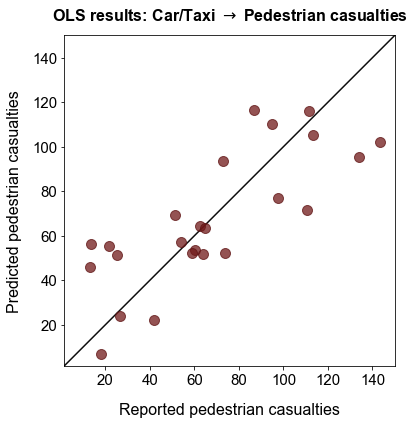

In [27]:
# showing the scatter plot

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(y_inversed, y_pred_inversed, marker= 'o', color= '#701919', s= 100, alpha= 0.75, edgecolors= '#601515')
ax.set_title(r"OLS results: Car/Taxi $\rightarrow$ Pedestrian casualties", pad= 15, weight = 'bold', size=16, **afont)
ax.set_xlabel('Reported pedestrian casualties', labelpad=15, size=16, **afont)
ax.set_ylabel('Predicted pedestrian casualties', labelpad=10, size=16, **afont)
plt.xticks(fontsize=15, **afont)
plt.yticks(fontsize=15, **afont)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes

# plotting the identity line
ax.plot(lims, lims, 'k-', alpha=0.95, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.grid(color='k', linestyle='-', linewidth=0.1)

# annotation of the cities
#for i, txt in enumerate(df_ped_car.City.tolist()):
#    plt.annotate(txt[:3], (y_inversed[i]-4, y_pred_inversed[i]+4), fontsize=15)

fig.tight_layout()
plt.show()

In [28]:
# showing the results as a table

results = pd.DataFrame([final.params, final.pvalues, final.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant', 1: cols[0], 2: cols[1], 3: cols[2], 4: cols[3]})#, 5: cols[4], 6: cols[5]})
conf_int = final.conf_int()
results['[0.025'] = conf_int.iloc[:,0]
results['0.975]'] = conf_int.iloc[:,1]
results

,parameters,p values,std,[0.025,0.975]
const,-2.775558e-16,1.000000,0.143337,-0.300007,0.300007
Cycling area share,-3.677840e-01,0.052805,0.178073,-0.740495,0.004927
Mode - walking (%),-4.788559e-01,0.007207,0.159111,-0.811878,-0.145834
Mode - cycling (%),-9.765943e-02,0.562288,0.165587,-0.444236,0.248917
Mode - public transport (%),8.698614e-02,0.575792,0.152783,-0.232792,0.406765


In [29]:
# preparing the final results table

#res.iloc[0,0] = 0
res.iloc[1,0] = results.iloc[1,0]
#res.iloc[2,0] = 0
res.iloc[3,0] = results.iloc[2,0]
res.iloc[4,0] = results.iloc[3,0]
res.iloc[5,0] = results.iloc[4,0]
#res.iloc[6,0] = results.iloc[5,0]
res

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
Density (pop./ sq km),NaN,NaN,NaN,NaN,NaN,NaN
Cycling area share,-0.367784,NaN,NaN,NaN,NaN,NaN
Speed limit area share,NaN,NaN,NaN,NaN,NaN,NaN
Mode - walking (%),-0.478856,NaN,NaN,NaN,NaN,NaN
Mode - cycling (%),-0.0976594,NaN,NaN,NaN,NaN,NaN
Mode - public transport (%),0.0869861,NaN,NaN,NaN,NaN,NaN
Mode - motor vehicles (%),NaN,NaN,NaN,NaN,NaN,NaN


---
### Variable selection for Cyclist - Car/Taxi casualties

In [30]:
# standardizing the target variable

scalery = StandardScaler(with_std=True)
data.iloc[:, 12] = scalery.fit_transform(data.iloc[:, 12].to_numpy().reshape(-1,1))

In [31]:
# selecting the input/output variables for the prediction task

target_col = "Cyclist - Car/Taxi"
X_columns = data.iloc[:, 4:11].columns
X = data.iloc[:, 4:11]
y = data.iloc[:, 12]

[Text(0.5, 0, 'Cyclist - Car/Taxi'),
 Text(1.5, 0, 'Mode - public transport (%)'),
 Text(2.5, 0, 'Mode - cycling (%)'),
 Text(3.5, 0, 'Mode - motor vehicles (%)'),
 Text(4.5, 0, 'Speed limit area share'),
 Text(5.5, 0, 'Density (pop./ sq km)'),
 Text(6.5, 0, 'Cycling area share'),
 Text(7.5, 0, 'Mode - walking (%)')]

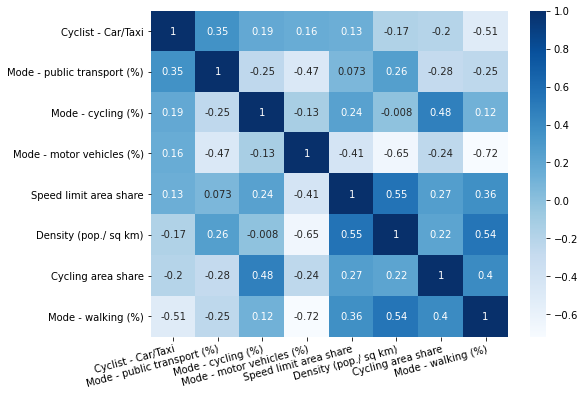

In [32]:
# showing the correlation heatmap

k = 11
columns = data.iloc[:, [4,5,6,7,8,9,10,12]].corr().nlargest(k, target_col)[target_col].index
cm = data[columns].corr()
plt.figure(figsize= (8,6))
hmap = sns.heatmap(cm, xticklabels= True, annot=True, cmap= 'Blues')
hmap.set_xticklabels(labels = hmap.get_xticklabels(), rotation= 15, ha="right", rotation_mode="anchor")

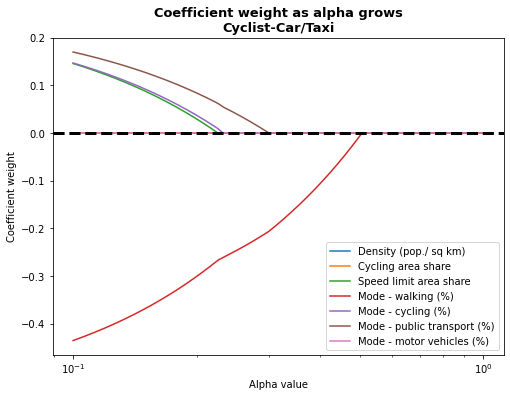

In [33]:
# showing the coefficient evolution as alpha changes

coefs = []
for alpha in alphas:    
    lasso = Lasso(alpha = alpha, fit_intercept = True, max_iter = 10000)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
lasso_fig = weight_versus_alpha_plot(coefs, alphas, data.columns[4:11], 
                                     'Coefficient weight as alpha grows\nCyclist-Car/Taxi')

In [34]:
# searching for the best estimator

kf = KFold(n_splits=3, shuffle = False)
lasso_regressor = GridSearchCV(Lasso(), params, scoring = 'neg_mean_squared_error', cv=kf)

lasso_regressor.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Lasso(),
             param_grid={'alpha': array([0.1       , 0.10023075, 0.10046204, 0.10069386, 0.10092622,
       0.10115911, 0.10139254, 0.10162651, 0.10186102, 0.10209607,
       0.10233166, 0.10256779, 0.10280447, 0.1030417 , 0.10327947,
       0.1035178 , 0.10375667, 0.10399609, 0.10423607, 0.1044766 ,
       0.10471768, 0.10495932, 0.10520...
       0.93534315, 0.9375015 , 0.93966483, 0.94183315, 0.94400648,
       0.94618482, 0.94836819, 0.95055659, 0.95275005, 0.95494856,
       0.95715215, 0.95936083, 0.9615746 , 0.96379348, 0.96601748,
       0.96824661, 0.97048089, 0.97272032, 0.97496492, 0.9772147 ,
       0.97946967, 0.98172984, 0.98399523, 0.98626585, 0.9885417 ,
       0.99082281, 0.99310918, 0.99540083, 0.99769776, 1.        ])},
             scoring='neg_mean_squared_error')

In [35]:
# best estimator

print('Mean with best score: ', lasso_regressor.best_score_)
print('Best estimator: ', lasso_regressor.best_estimator_)

lasso_best = lasso_regressor.best_estimator_

lasso_best.fit(X,y)

Mean with best score:  -1.216750478790382
Best estimator:  Lasso(alpha=0.1)


Lasso(alpha=0.1)

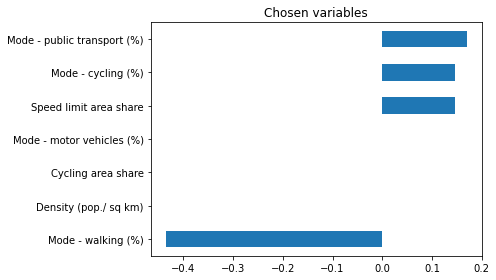

In [36]:
# showing the variables chosen by the best estimator

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (7, 4))
coef.plot(kind='barh', title = 'Chosen variables')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

In [37]:
# identifying chosen urban features

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef = coef.to_frame().reset_index().rename(columns={0: 'Value', 'index': 'Coefficient'})
coef_in = (coef.Value != 0)
coef_list = (coef_in.index[coef_in] + 4).tolist()

In [38]:
# setting the input/output variables for the prediction

cols = data.iloc[:, coef_list].columns.tolist()
X = data.iloc[:, coef_list].values
y = y.values

In [39]:
# prediction with the selected variables and 3-fold cross-validation

results = prediction(X, y, folds=3)

============================ FOLD NUMBER 1 ===================================
TRAIN: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
TEST: [0 1 2 3 4 5 6 7]
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     3.245
Date:                Wed, 14 Apr 2021   Prob (F-statistic):             0.0547
Time:                        00:02:11   Log-Likelihood:                -17.465
No. Observations:                  16   AIC:                             44.93
Df Residuals:                      11   BIC:                             48.79
Df Model:                           4                                         
Covariance Type:            nonrobust             

### Final model Cyclist - Car/Taxi casualties

In [40]:
# final model with selected variables

X = data.iloc[:, coef_list]
y = data.iloc[:, 12]

In [41]:
# final OLS regression

X = sm.add_constant(X)
final = sm.OLS(y, X).fit()
p = final.params
print(final.summary())

print('\n')
print('R2: ', final.rsquared)
print('Predicted values: ', final.predict())

                            OLS Regression Results                            
Dep. Variable:     Cyclist - Car/Taxi   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     4.076
Date:                Wed, 14 Apr 2021   Prob (F-statistic):             0.0150
Time:                        00:02:11   Log-Likelihood:                -26.620
No. Observations:                  24   AIC:                             63.24
Df Residuals:                      19   BIC:                             69.13
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [42]:
# inverse transformation of the data

y_pred_inversed = scalery.inverse_transform(final.fittedvalues)
y_pred_inversed

array([41.42356535,  7.10708583, 23.47094496, 19.11413433, 13.05140444,
        1.22291478, 11.45140852, 28.28722327, -6.4759467 , 14.0620462 ,
       20.77543808, 27.38760203, 38.86211175, 46.61499548, 58.78036472,
       25.4183833 , 23.14204663, 53.21071196, 43.05204888, 52.82800386,
       43.77632152, 42.87593592, 45.89216661, 25.47908828])

In [43]:
# inverse transformation of the data

y_inversed = scalery.inverse_transform(y)
y_inversed

array([ 3.09,  5.58, 19.65,  4.3 , 21.31, 10.42, 14.03, 22.63,  5.88,
        6.4 , 28.47,  4.17, 47.31, 26.06, 60.42, 28.93, 36.72, 63.36,
       54.57, 94.44, 62.09, 66.95,  5.22,  8.81])

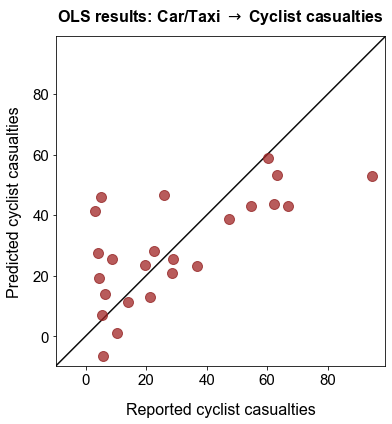

In [44]:
# showing the scatter plot

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(y_inversed, y_pred_inversed, marker= 'o', color= '#a12424', s= 100, alpha= 0.75, edgecolors= '#912020')
ax.set_title(r"OLS results: Car/Taxi $\rightarrow$ Cyclist casualties", pad= 15, weight = 'bold', size=16, **afont)
ax.set_xlabel('Reported cyclist casualties', labelpad=15, size=16, **afont)
ax.set_ylabel('Predicted cyclist casualties', labelpad=10, size=16, **afont)
plt.xticks(fontsize=15, **afont)
plt.yticks(fontsize=15, **afont)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plotting the identity line
ax.plot(lims, lims, 'k-', alpha=0.95, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.grid(color='k', linestyle='-', linewidth=0.1)

# annotation of the cities
#for i, txt in enumerate(df_ped_car.City.tolist()):
#    plt.annotate(txt[:3], (y_inversed[i]-3, y_pred_inversed[i]+2.5), fontsize=15)

fig.tight_layout()
plt.show()

In [45]:
# showing the results as a table

results = pd.DataFrame([final.params, final.pvalues, final.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant', 1: cols[0], 2: cols[1], 3: cols[2]})#, 4: cols[3], 5: cols[4], 6: cols[5]})
conf_int = final.conf_int()
results['[0.025'] = conf_int.iloc[:,0]
results['0.975]'] = conf_int.iloc[:,1]
results

,parameters,p values,std,[0.025,0.975]
const,-7.632783e-17,1.000000,0.168301,-0.352259,0.352259
Speed limit area share,2.619689e-01,0.185010,0.190468,-0.136686,0.660624
Mode - walking (%),-5.699348e-01,0.007161,0.189190,-0.965914,-0.173956
Mode - cycling (%),2.563370e-01,0.171943,0.180579,-0.121618,0.634292
Mode - public transport (%),2.556175e-01,0.180216,0.183727,-0.128928,0.640163


In [46]:
# preparing the final results table

#res.iloc[0,1] = results.iloc[1,0]
#res.iloc[1,1] = results.iloc[2,0]
res.iloc[2,1] = results.iloc[1,0]
res.iloc[3,1] = results.iloc[2,0]
res.iloc[4,1] = results.iloc[3,0]
res.iloc[5,1] = results.iloc[4,0]
#res.iloc[6,1] = np.NaN
res

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
Density (pop./ sq km),NaN,NaN,NaN,NaN,NaN,NaN
Cycling area share,-0.367784,NaN,NaN,NaN,NaN,NaN
Speed limit area share,NaN,0.261969,NaN,NaN,NaN,NaN
Mode - walking (%),-0.478856,-0.569935,NaN,NaN,NaN,NaN
Mode - cycling (%),-0.0976594,0.256337,NaN,NaN,NaN,NaN
Mode - public transport (%),0.0869861,0.255617,NaN,NaN,NaN,NaN
Mode - motor vehicles (%),NaN,NaN,NaN,NaN,NaN,NaN


---
### Variable selection for PTW occ. - Car/Taxi casualties

In [47]:
# standardizing the target variable

scalery = StandardScaler(with_std=True)
data.iloc[:, 13] = scalery.fit_transform(data.iloc[:, 13].to_numpy().reshape(-1,1))

In [48]:
# selecting the input/output variables for the prediction task

target_col = "PTW occ. - Car/Taxi"
X_columns = data.iloc[:, 4:11].columns
X = data.iloc[:, 4:11]
y = data.iloc[:, 13]

[Text(0.5, 0, 'PTW occ. - Car/Taxi'),
 Text(1.5, 0, 'Mode - walking (%)'),
 Text(2.5, 0, 'Density (pop./ sq km)'),
 Text(3.5, 0, 'Mode - motor vehicles (%)'),
 Text(4.5, 0, 'Speed limit area share'),
 Text(5.5, 0, 'Mode - public transport (%)'),
 Text(6.5, 0, 'Mode - cycling (%)'),
 Text(7.5, 0, 'Cycling area share')]

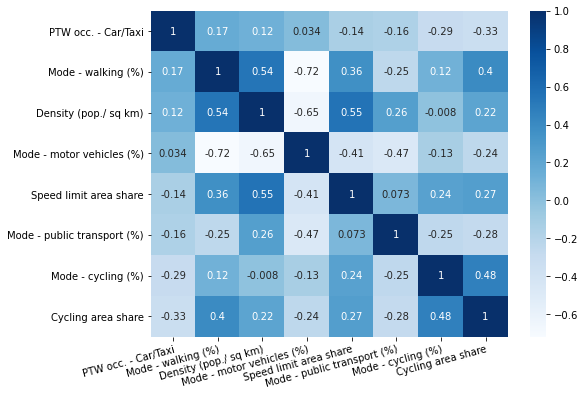

In [49]:
# showing the correlation heatmap

k = 11
columns = data.iloc[:, [4,5,6,7,8,9,10,13]].corr().nlargest(k, target_col)[target_col].index
cm = data[columns].corr()
plt.figure(figsize= (8,6))
hmap = sns.heatmap(cm, xticklabels= True, annot=True, cmap= 'Blues')
hmap.set_xticklabels(labels = hmap.get_xticklabels(), rotation= 15, ha="right", rotation_mode="anchor")

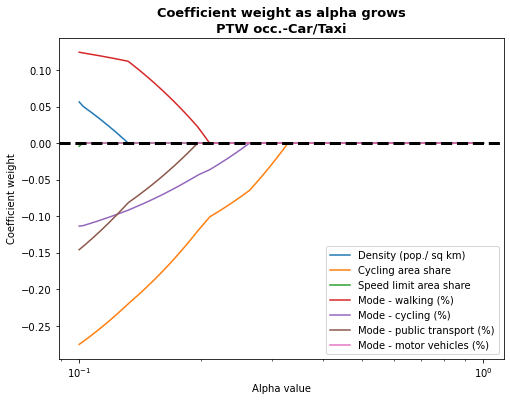

In [50]:
# showing the coefficient evolution as alpha changes

coefs = []
for alpha in alphas:    
    lasso = Lasso(alpha = alpha, fit_intercept = True, max_iter = 10000)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
lasso_fig = weight_versus_alpha_plot(coefs, alphas, data.columns[4:11],
                                     'Coefficient weight as alpha grows\nPTW occ.-Car/Taxi')

In [51]:
# searching for the best estimator

kf = KFold(n_splits=3, shuffle = False)
lasso_regressor = GridSearchCV(Lasso(), params, scoring = 'neg_mean_squared_error', cv=kf)

lasso_regressor.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Lasso(),
             param_grid={'alpha': array([0.1       , 0.10023075, 0.10046204, 0.10069386, 0.10092622,
       0.10115911, 0.10139254, 0.10162651, 0.10186102, 0.10209607,
       0.10233166, 0.10256779, 0.10280447, 0.1030417 , 0.10327947,
       0.1035178 , 0.10375667, 0.10399609, 0.10423607, 0.1044766 ,
       0.10471768, 0.10495932, 0.10520...
       0.93534315, 0.9375015 , 0.93966483, 0.94183315, 0.94400648,
       0.94618482, 0.94836819, 0.95055659, 0.95275005, 0.95494856,
       0.95715215, 0.95936083, 0.9615746 , 0.96379348, 0.96601748,
       0.96824661, 0.97048089, 0.97272032, 0.97496492, 0.9772147 ,
       0.97946967, 0.98172984, 0.98399523, 0.98626585, 0.9885417 ,
       0.99082281, 0.99310918, 0.99540083, 0.99769776, 1.        ])},
             scoring='neg_mean_squared_error')

In [52]:
# best estimator

print('Mean with best score: ', lasso_regressor.best_score_)
print('Best estimator: ', lasso_regressor.best_estimator_)

lasso_best = lasso_regressor.best_estimator_

lasso_best.fit(X,y)

Mean with best score:  -1.0543627561852196
Best estimator:  Lasso(alpha=0.3806979871402286)


Lasso(alpha=0.3806979871402286)

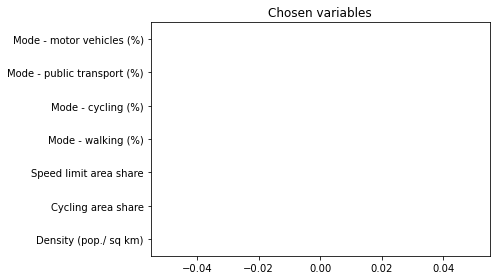

In [53]:
# showing the variables chosen by the best estimator

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (7, 4))
coef.plot(kind='barh', title = 'Chosen variables')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

In [54]:
# identifying chosen urban features

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef = coef.to_frame().reset_index().rename(columns={0: 'Value', 'index': 'Coefficient'})
coef_in = (coef.Value != 0)
coef_list = (coef_in.index[coef_in] + 4).tolist()

In [55]:
# setting the input/output variables for the prediction

cols = data.iloc[:, coef_list].columns.tolist()
X = data.iloc[:, coef_list].values
y = y.values

In [56]:
# IMPORTANT: since no variables were chosen, we didn't proceed with the prediction task in 3 folds

#results = prediction(X, y, folds=3)

### Final model PTW occ. - Car/Taxi casualties

In [57]:
# final model with selected variables

X = data.iloc[:, coef_list]
y = data.iloc[:, 13]

In [58]:
# final OLS regression

X = sm.add_constant(X)
final = sm.OLS(y, X).fit()
p = final.params
print(final.summary())

print('\n')
print('R2: ', final.rsquared)
print('Predicted values: ', final.predict())

                             OLS Regression Results                            
Dep. Variable:     PTW occ. - Car/Taxi   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                       nan
Date:                 Wed, 14 Apr 2021   Prob (F-statistic):                nan
Time:                         00:02:53   Log-Likelihood:                -34.055
No. Observations:                   24   AIC:                             70.11
Df Residuals:                       23   BIC:                             71.29
Df Model:                            0                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.714e-17      0.209   4.66e-1

In [59]:
# inverse transformation of the data

y_pred_inversed = scalery.inverse_transform(final.fittedvalues)
y_pred_inversed

array([62.26291667, 62.26291667, 62.26291667, 62.26291667, 62.26291667,
       62.26291667, 62.26291667, 62.26291667, 62.26291667, 62.26291667,
       62.26291667, 62.26291667, 62.26291667, 62.26291667, 62.26291667,
       62.26291667, 62.26291667, 62.26291667, 62.26291667, 62.26291667,
       62.26291667, 62.26291667, 62.26291667, 62.26291667])

In [60]:
# inverse transformation of the data

y_inversed = scalery.inverse_transform(y)
y_inversed

array([ 59.25,  85.32,  55.02,  30.07,  75.57, 169.12,  73.65,  42.02,
       147.05,  60.34,  28.47,  60.47,  48.19,  20.48,  47.47,  32.79,
        25.54,  54.49,  44.46, 103.05,  56.61,  51.5 , 120.44,   2.94])

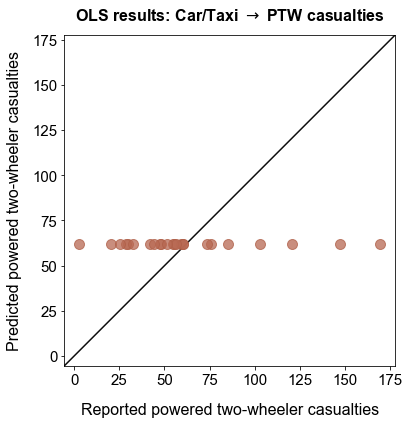

In [61]:
# showing the scatter plot

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(y_inversed, y_pred_inversed, marker= 'o', color= '#b86953', s= 100, alpha= 0.75, edgecolors= '#af5f48')
ax.set_title(r"OLS results: Car/Taxi $\rightarrow$ PTW casualties", pad= 15, weight = 'bold', size=16, **afont)
ax.set_xlabel('Reported powered two-wheeler casualties', labelpad=15, size=16, **afont)
ax.set_ylabel('Predicted powered two-wheeler casualties', labelpad=10, size=16, **afont)
plt.xticks(fontsize=15, **afont)
plt.yticks(fontsize=15, **afont)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plotting the identity line
ax.plot(lims, lims, 'k-', alpha=0.95, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.grid(color='k', linestyle='-', linewidth=0.1)

# annotation of the cities
#for i, txt in enumerate(df_ped_car.City.tolist()):
#    plt.annotate(txt[:3], (y_inversed[i]-4, y_pred_inversed[i]+4), fontsize=15)

fig.tight_layout()
plt.show()

In [62]:
# showing the results as a table

results = pd.DataFrame([final.params, final.pvalues, final.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant'})#, 1: cols[0], 2: cols[1], 3: cols[2], 4: cols[3]})#, 
                                                                                #5: cols[4], 6: cols[5], 7: cols[6], 8: cols[7]})
conf_int = final.conf_int()
results['[0.025'] = conf_int.iloc[:,0]
results['0.975]'] = conf_int.iloc[:,1]
results

,parameters,p values,std,[0.025,0.975]
const,9.714451e-17,1.0,0.208514,-0.431345,0.431345


In [63]:
# preparing the final results table
# IMPORTANT: since no variables were chosen, there are no results to display

---
### Variable selection for PTW occ. - Itself casualties

In [64]:
# standardizing the target variable

scalery = StandardScaler(with_std=True)
data.iloc[:, 14] = scalery.fit_transform(data.iloc[:, 14].to_numpy().reshape(-1,1))

In [65]:
# selecting the input/output variables for the prediction task

target_col = "PTW occ. - Itself"
X_columns = data.iloc[:, 4:11].columns
X = data.iloc[:, 4:11]
y = data.iloc[:, 14]

[Text(0.5, 0, 'PTW occ. - Itself'),
 Text(1.5, 0, 'Density (pop./ sq km)'),
 Text(2.5, 0, 'Mode - walking (%)'),
 Text(3.5, 0, 'Mode - public transport (%)'),
 Text(4.5, 0, 'Mode - motor vehicles (%)'),
 Text(5.5, 0, 'Cycling area share'),
 Text(6.5, 0, 'Speed limit area share'),
 Text(7.5, 0, 'Mode - cycling (%)')]

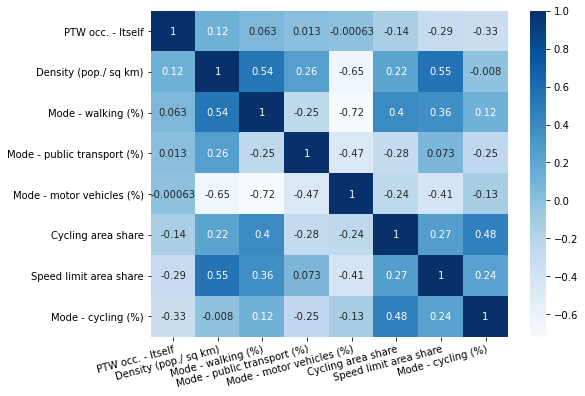

In [66]:
# showing the correlation heatmap

k = 11
columns = data.iloc[:, [4,5,6,7,8,9,10,14]].corr().nlargest(k, target_col)[target_col].index
cm = data[columns].corr()
plt.figure(figsize= (8,6))
hmap = sns.heatmap(cm, xticklabels= True, annot=True, cmap= 'Blues')
hmap.set_xticklabels(labels = hmap.get_xticklabels(), rotation= 15, ha="right", rotation_mode="anchor")

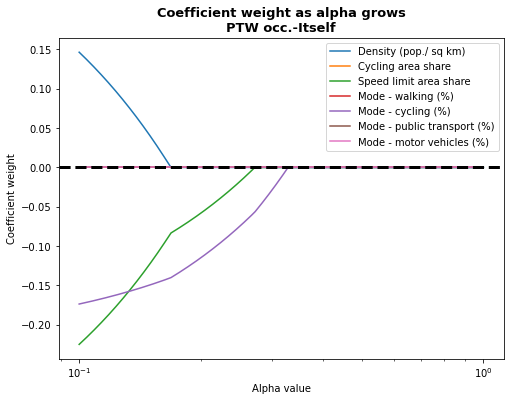

In [67]:
# showing the coefficient evolution as alpha changes

coefs = []
for alpha in alphas:    
    lasso = Lasso(alpha = alpha, fit_intercept = True, max_iter = 10000)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
lasso_fig = weight_versus_alpha_plot(coefs, alphas, data.columns[4:11],
                                     'Coefficient weight as alpha grows\nPTW occ.-Itself')

In [68]:
# searching for the best estimator

kf = KFold(n_splits=3, shuffle = False)
lasso_regressor = GridSearchCV(Lasso(), params, scoring = 'neg_mean_squared_error', cv=kf)

lasso_regressor.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Lasso(),
             param_grid={'alpha': array([0.1       , 0.10023075, 0.10046204, 0.10069386, 0.10092622,
       0.10115911, 0.10139254, 0.10162651, 0.10186102, 0.10209607,
       0.10233166, 0.10256779, 0.10280447, 0.1030417 , 0.10327947,
       0.1035178 , 0.10375667, 0.10399609, 0.10423607, 0.1044766 ,
       0.10471768, 0.10495932, 0.10520...
       0.93534315, 0.9375015 , 0.93966483, 0.94183315, 0.94400648,
       0.94618482, 0.94836819, 0.95055659, 0.95275005, 0.95494856,
       0.95715215, 0.95936083, 0.9615746 , 0.96379348, 0.96601748,
       0.96824661, 0.97048089, 0.97272032, 0.97496492, 0.9772147 ,
       0.97946967, 0.98172984, 0.98399523, 0.98626585, 0.9885417 ,
       0.99082281, 0.99310918, 0.99540083, 0.99769776, 1.        ])},
             scoring='neg_mean_squared_error')

In [69]:
# best estimator

print('Mean with best score: ', lasso_regressor.best_score_)
print('Best estimator: ', lasso_regressor.best_estimator_)

lasso_best = lasso_regressor.best_estimator_

lasso_best.fit(X,y)

Mean with best score:  -1.1843305378540847
Best estimator:  Lasso(alpha=0.31009266359319265)


Lasso(alpha=0.31009266359319265)

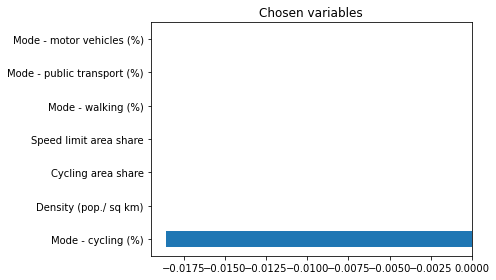

In [70]:
# showing the variables chosen by the best estimator

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (7, 4))
coef.plot(kind='barh', title = 'Chosen variables')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

In [71]:
# identifying chosen urban features

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef = coef.to_frame().reset_index().rename(columns={0: 'Value', 'index': 'Coefficient'})
coef_in = (coef.Value != 0)
coef_list = (coef_in.index[coef_in] + 4).tolist()

In [72]:
# setting the input/output variables for the prediction

cols = data.iloc[:, coef_list].columns.tolist()
X = data.iloc[:, coef_list].values
y = y.values

In [73]:
# prediction with the selected variables and 3-fold cross-validation

results = prediction(X, y, folds=3)

============================ FOLD NUMBER 1 ===================================
TRAIN: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
TEST: [0 1 2 3 4 5 6 7]
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.255
Date:                Wed, 14 Apr 2021   Prob (F-statistic):              0.281
Time:                        00:03:25   Log-Likelihood:                -20.130
No. Observations:                  16   AIC:                             44.26
Df Residuals:                      14   BIC:                             45.81
Df Model:                           1                                         
Covariance Type:            nonrobust             

### Final model PTW occ. - Itself casualties

In [74]:
# final model with selected variables

X = data.iloc[:, coef_list]
y = data.iloc[:, 14]

In [75]:
# final OLS regression

X = sm.add_constant(X)
final = sm.OLS(y, X).fit()
p = final.params
print(final.summary())

print('\n')
print('R2: ', final.rsquared)
print('Predicted values: ', final.predict())

                            OLS Regression Results                            
Dep. Variable:      PTW occ. - Itself   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.664
Date:                Wed, 14 Apr 2021   Prob (F-statistic):              0.117
Time:                        00:03:25   Log-Likelihood:                -32.683
No. Observations:                  24   AIC:                             69.37
Df Residuals:                      22   BIC:                             71.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.551e-17      0

In [76]:
# inverse transformation of the data

y_pred_inversed = scalery.inverse_transform(final.fittedvalues)
y_pred_inversed

array([17.75755774, 20.0771638 , 16.25132003, 17.75755774, 17.75755774,
       19.26379544, 17.75755774, 13.23884463, 19.26379544, 16.25132003,
        8.72013151, 16.25132003, 17.75755774, 19.26379544, -0.31729472,
       17.75755774, 19.26379544, 19.26379544, 17.75755774, 16.25132003,
       17.75755774, 19.26379544, 19.26379544, 13.23884463])

In [77]:
# inverse transformation of the data

y_inversed = scalery.inverse_transform(y)
y_inversed

array([17.9 , 29.47,  7.86,  8.59, 23.25, 52.12, 28.06, 19.4 , 17.65,
       21.94, 14.24, 10.43,  5.26, 14.89,  2.16,  1.93,  3.19, 21.54,
       10.1 , 20.  ,  7.3 ,  6.87, 49.78,  2.94])

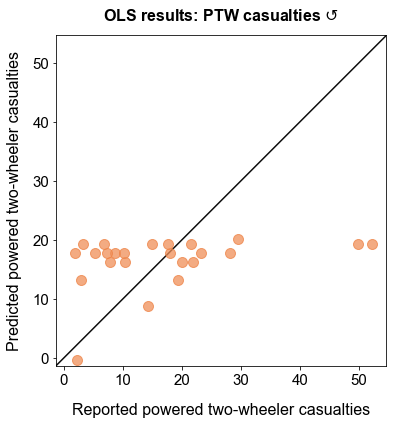

In [78]:
# showing the scatter plot

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(y_inversed, y_pred_inversed, marker= 'o', color= '#f08f58', s= 100, alpha= 0.75, edgecolors= '#ee8346')
ax.set_title(r"OLS results: PTW casualties $\circlearrowleft$", pad= 15, weight = 'bold', size=16, **afont)
ax.set_xlabel('Reported powered two-wheeler casualties', labelpad=15, size=16, **afont)
ax.set_ylabel('Predicted powered two-wheeler casualties', labelpad=10, size=16, **afont)
plt.xticks(fontsize=15, **afont)
plt.yticks(fontsize=15, **afont)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plotting the identity line
ax.plot(lims, lims, 'k-', alpha=0.95, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.grid(color='k', linestyle='-', linewidth=0.1)

# annotation of the cities
#for i, txt in enumerate(df_ped_car.City.tolist()):
#    plt.annotate(txt[:3], (y_inversed[i]-1, y_pred_inversed[i]+1.2), fontsize=15)

fig.tight_layout()
plt.show()

In [79]:
# showing the results as a table

results = pd.DataFrame([final.params, final.pvalues, final.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant', 1: cols[0]})#, 2: cols[1], 3: cols[2], 4: cols[3], 
                                                                                 #5: cols[4], 6: cols[5], 7: cols[6], 8: cols[7]})
conf_int = final.conf_int()
results['[0.025'] = conf_int.iloc[:,0]
results['0.975]'] = conf_int.iloc[:,1]
results

,parameters,p values,std,[0.025,0.975]
const,5.551115e-17,1.00000,0.201357,-0.417588,0.417588
Mode - cycling (%),-3.286638e-01,0.11686,0.201357,-0.746252,0.088925


In [80]:
# preparing the final results table

#res.iloc[0,3] = 0
#res.iloc[1,3] = 0
#res.iloc[2,3] = 0
#res.iloc[3,3] = 0
res.iloc[4,3] = results.iloc[1,0]
#res.iloc[5,3] = 0
res

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
Density (pop./ sq km),NaN,NaN,NaN,NaN,NaN,NaN
Cycling area share,-0.367784,NaN,NaN,NaN,NaN,NaN
Speed limit area share,NaN,0.261969,NaN,NaN,NaN,NaN
Mode - walking (%),-0.478856,-0.569935,NaN,NaN,NaN,NaN
Mode - cycling (%),-0.0976594,0.256337,NaN,-0.328664,NaN,NaN
Mode - public transport (%),0.0869861,0.255617,NaN,NaN,NaN,NaN
Mode - motor vehicles (%),NaN,NaN,NaN,NaN,NaN,NaN


---
### Variable selection for Car/Taxi occ. - Car/Taxi casualties

In [81]:
# standardizing the target variable

scalery = StandardScaler(with_std=True)
data.iloc[:, 15] = scalery.fit_transform(data.iloc[:, 15].to_numpy().reshape(-1,1))

In [82]:
# selecting the input/output variables for the prediction task

target_col = "Car/Taxi occ. - Car/Taxi"
X_columns = data.iloc[:, 4:11].columns
X = data.iloc[:, 4:11]
y = data.iloc[:, 15]

[Text(0.5, 0, 'Car/Taxi occ. - Car/Taxi'),
 Text(1.5, 0, 'Mode - motor vehicles (%)'),
 Text(2.5, 0, 'Mode - public transport (%)'),
 Text(3.5, 0, 'Mode - cycling (%)'),
 Text(4.5, 0, 'Density (pop./ sq km)'),
 Text(5.5, 0, 'Speed limit area share'),
 Text(6.5, 0, 'Cycling area share'),
 Text(7.5, 0, 'Mode - walking (%)')]

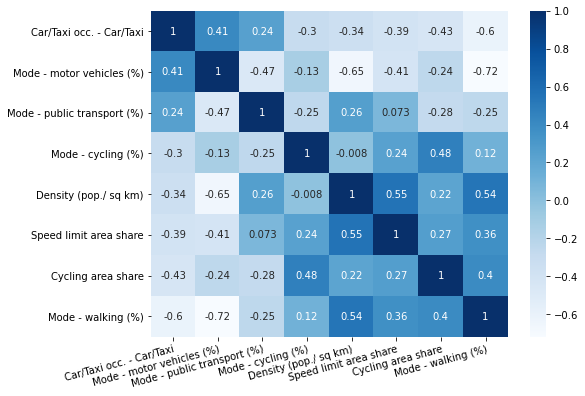

In [83]:
# showing the correlation heatmap

k = 11
columns = data.iloc[:, [4,5,6,7,8,9,10,15]].corr().nlargest(k, target_col)[target_col].index
cm = data[columns].corr()
plt.figure(figsize= (8,6))
hmap = sns.heatmap(cm, xticklabels= True, annot=True, cmap= 'Blues')
hmap.set_xticklabels(labels = hmap.get_xticklabels(), rotation= 15, ha="right", rotation_mode="anchor")

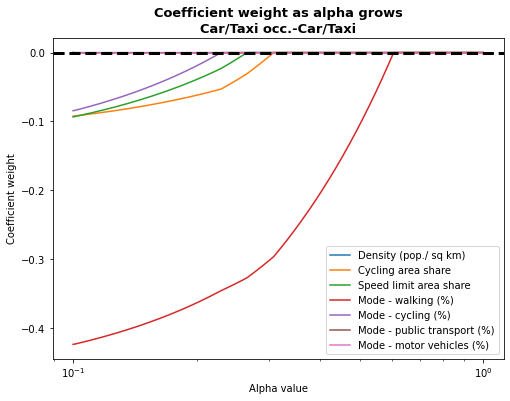

In [84]:
# showing the coefficient evolution as alpha changes

coefs = []
for alpha in alphas:    
    lasso = Lasso(alpha = alpha, fit_intercept = True, max_iter = 10000)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
lasso_fig = weight_versus_alpha_plot(coefs, alphas, data.columns[4:11],
                                     'Coefficient weight as alpha grows\nCar/Taxi occ.-Car/Taxi')

In [85]:
# searching for the best estimator

kf = KFold(n_splits=3, shuffle = False)
lasso_regressor = GridSearchCV(Lasso(), params, scoring = 'neg_mean_squared_error', cv=kf)

lasso_regressor.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Lasso(),
             param_grid={'alpha': array([0.1       , 0.10023075, 0.10046204, 0.10069386, 0.10092622,
       0.10115911, 0.10139254, 0.10162651, 0.10186102, 0.10209607,
       0.10233166, 0.10256779, 0.10280447, 0.1030417 , 0.10327947,
       0.1035178 , 0.10375667, 0.10399609, 0.10423607, 0.1044766 ,
       0.10471768, 0.10495932, 0.10520...
       0.93534315, 0.9375015 , 0.93966483, 0.94183315, 0.94400648,
       0.94618482, 0.94836819, 0.95055659, 0.95275005, 0.95494856,
       0.95715215, 0.95936083, 0.9615746 , 0.96379348, 0.96601748,
       0.96824661, 0.97048089, 0.97272032, 0.97496492, 0.9772147 ,
       0.97946967, 0.98172984, 0.98399523, 0.98626585, 0.9885417 ,
       0.99082281, 0.99310918, 0.99540083, 0.99769776, 1.        ])},
             scoring='neg_mean_squared_error')

In [86]:
# best estimator

print('Mean with best score: ', lasso_regressor.best_score_)
print('Best estimator: ', lasso_regressor.best_estimator_)

lasso_best = lasso_regressor.best_estimator_

lasso_best.fit(X,y)

Mean with best score:  -0.7435833304925873
Best estimator:  Lasso(alpha=0.1)


Lasso(alpha=0.1)

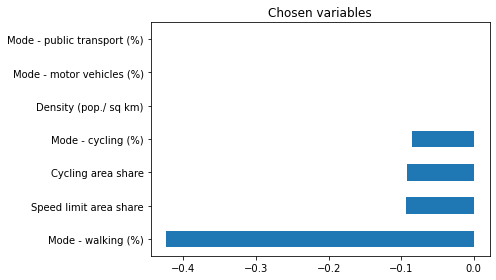

In [87]:
# showing the variables chosen by the best estimator

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (7, 4))
coef.plot(kind='barh', title = 'Chosen variables')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

In [88]:
# identifying chosen urban features

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef = coef.to_frame().reset_index().rename(columns={0: 'Value', 'index': 'Coefficient'})
coef_in = (coef.Value != 0)
coef_list = (coef_in.index[coef_in] + 4).tolist()

In [89]:
# setting the input/output variables for the prediction

cols = data.iloc[:, coef_list].columns.tolist()
X = data.iloc[:, coef_list].values
y = y.values

In [90]:
# prediction with the selected variables and 3-fold cross-validation

results = prediction(X, y, folds=3)

============================ FOLD NUMBER 1 ===================================
TRAIN: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
TEST: [0 1 2 3 4 5 6 7]
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     1.740
Date:                Wed, 14 Apr 2021   Prob (F-statistic):              0.213
Time:                        00:04:05   Log-Likelihood:                -19.845
No. Observations:                  16   AIC:                             51.69
Df Residuals:                      10   BIC:                             56.33
Df Model:                           5                                         
Covariance Type:            nonrobust             

### Final model Car/Taxi occ. - Car/Taxi casualties

In [91]:
# final model with selected variables

X = data.iloc[:, coef_list]
y = data.iloc[:, 15]

In [92]:
# final OLS regression

X = sm.add_constant(X)
final = sm.OLS(y, X).fit()
p = final.params
print(final.summary())

print('\n')
print('R2: ', final.rsquared)
print('Predicted values: ', final.predict())

                               OLS Regression Results                               
Dep. Variable:     Car/Taxi occ. - Car/Taxi   R-squared:                       0.454
Model:                                  OLS   Adj. R-squared:                  0.302
Method:                       Least Squares   F-statistic:                     2.989
Date:                      Wed, 14 Apr 2021   Prob (F-statistic):             0.0389
Time:                              00:04:05   Log-Likelihood:                -26.800
No. Observations:                        24   AIC:                             65.60
Df Residuals:                            18   BIC:                             72.67
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [93]:
# inverse transformation of the data

y_pred_inversed = scalery.inverse_transform(final.fittedvalues)
y_pred_inversed

array([20.32386862, 39.49320923, 43.42283195, 18.00839437, 26.627299  ,
       34.14575352, 36.85811901, 17.0285471 , 24.50327066, -1.19706323,
        4.98385963, 33.59783937, 68.58566917, 89.22919811, 18.94947785,
       13.48316392, 51.34657811, 88.99749121, 68.69734318, 28.21177895,
       62.17617623, 80.63421491, 89.23110223, 24.6218769 ])

In [94]:
# inverse transformation of the data

y_inversed = scalery.inverse_transform(y)
y_inversed

array([  2.47,  22.34,   3.93,  25.77,  40.69,  55.6 ,  42.09,  19.4 ,
        17.65,  10.97,  10.68,  25.02, 106.89,  57.71,  23.74,  27.  ,
        22.35,  67.16,  44.46,  34.16,  51.13, 192.27,  75.54,   2.94])

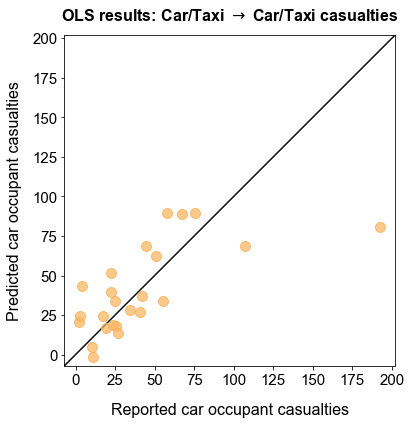

In [95]:
# showing the scatter plot

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(y_inversed, y_pred_inversed, marker= 'o', color= '#f9b765', s= 100, alpha= 0.75, edgecolors= '#f8ae52')
ax.set_title(r"OLS results: Car/Taxi $\rightarrow$ Car/Taxi casualties", pad= 15, weight = 'bold', size=16, **afont)
ax.set_xlabel('Reported car occupant casualties', labelpad=15, size=16, **afont)
ax.set_ylabel('Predicted car occupant casualties', labelpad=10, size=16, **afont)
plt.xticks(fontsize=15, **afont)
plt.yticks(fontsize=15, **afont)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plotting the identity line
ax.plot(lims, lims, 'k-', alpha=0.95, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.grid(color='k', linestyle='-', linewidth=0.1)

# annotation of the cities
#for i, txt in enumerate(df_ped_car.City.tolist()):
#    plt.annotate(txt[:3], (y_inversed[i]-4, y_pred_inversed[i]+4), fontsize=15)

fig.tight_layout()
plt.show()

In [96]:
# showing the results as a table

results = pd.DataFrame([final.params, final.pvalues, final.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant', 1: cols[0], 2: cols[1], 3: cols[2], 4: cols[3],5: cols[4]}) 
                                                                                 #5: cols[4], 6: cols[5], 7: cols[6], 8: cols[7]})
conf_int = final.conf_int()
results['[0.025'] = conf_int.iloc[:,0]
results['0.975]'] = conf_int.iloc[:,1]
results

,parameters,p values,std,[0.025,0.975]
const,4.857226e-17,1.000000,0.174217,-0.366016,0.366016
Cycling area share,-1.117312e-01,0.613104,0.217129,-0.567902,0.344439
Speed limit area share,-1.677356e-01,0.407555,0.197793,-0.583284,0.247813
Mode - walking (%),-4.641727e-01,0.037128,0.206217,-0.897419,-0.030927
Mode - cycling (%),-1.331548e-01,0.525582,0.205695,-0.565304,0.298994
Mode - public transport (%),7.860494e-02,0.686562,0.191666,-0.324071,0.481281


In [97]:
# preparing the final results table

#res.iloc[0,4] = 0
res.iloc[1,4] = results.iloc[1,0]
res.iloc[2,4] = results.iloc[2,0]
res.iloc[3,4] = results.iloc[3,0]
res.iloc[4,4] = results.iloc[4,0]
res.iloc[5,4] = results.iloc[5,0]
res

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
Density (pop./ sq km),NaN,NaN,NaN,NaN,NaN,NaN
Cycling area share,-0.367784,NaN,NaN,NaN,-0.111731,NaN
Speed limit area share,NaN,0.261969,NaN,NaN,-0.167736,NaN
Mode - walking (%),-0.478856,-0.569935,NaN,NaN,-0.464173,NaN
Mode - cycling (%),-0.0976594,0.256337,NaN,-0.328664,-0.133155,NaN
Mode - public transport (%),0.0869861,0.255617,NaN,NaN,0.0786049,NaN
Mode - motor vehicles (%),NaN,NaN,NaN,NaN,NaN,NaN


---
### Variable selection for Car/Taxi occ. - Itself casualties

In [98]:
# standardizing the target variable

scalery = StandardScaler(with_std=True)
data.iloc[:, 16] = scalery.fit_transform(data.iloc[:, 16].to_numpy().reshape(-1,1))

In [99]:
# selecting the input/output variables for the prediction task

target_col = "Car/Taxi occ. - Itself"
X_columns = data.iloc[:, 4:11].columns
X = data.iloc[:, 4:11]
y = data.iloc[:, 16]

[Text(0.5, 0, 'Car/Taxi occ. - Itself'),
 Text(1.5, 0, 'Mode - motor vehicles (%)'),
 Text(2.5, 0, 'Mode - public transport (%)'),
 Text(3.5, 0, 'Mode - cycling (%)'),
 Text(4.5, 0, 'Density (pop./ sq km)'),
 Text(5.5, 0, 'Cycling area share'),
 Text(6.5, 0, 'Mode - walking (%)'),
 Text(7.5, 0, 'Speed limit area share')]

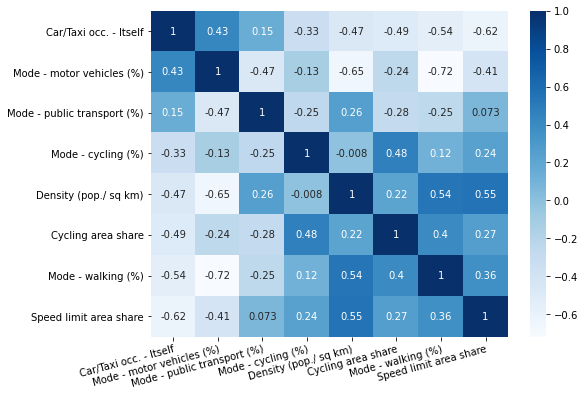

In [100]:
# showing the correlation heatmap

k = 11
columns = data.iloc[:,[4,5,6,7,8,9,10,16]].corr().nlargest(k, target_col)[target_col].index
cm = data[columns].corr()
plt.figure(figsize= (8,6))
hmap = sns.heatmap(cm, xticklabels= True, annot=True, cmap= 'Blues')
hmap.set_xticklabels(labels = hmap.get_xticklabels(), rotation= 15, ha="right", rotation_mode="anchor")

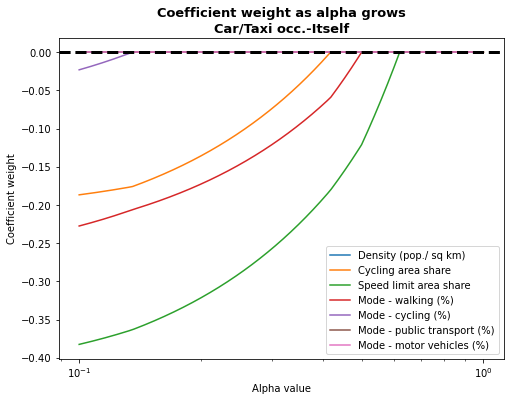

In [101]:
# showing the coefficient evolution as alpha changes

coefs = []
for alpha in alphas:    
    lasso = Lasso(alpha = alpha, fit_intercept = True, max_iter = 10000)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
lasso_fig = weight_versus_alpha_plot(coefs, alphas, data.columns[4:11],
                                     'Coefficient weight as alpha grows\nCar/Taxi occ.-Itself')

In [102]:
# searching for the best estimator

kf = KFold(n_splits=3, shuffle = False)
lasso_regressor = GridSearchCV(Lasso(), params, scoring = 'neg_mean_squared_error', cv=kf)

lasso_regressor.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Lasso(),
             param_grid={'alpha': array([0.1       , 0.10023075, 0.10046204, 0.10069386, 0.10092622,
       0.10115911, 0.10139254, 0.10162651, 0.10186102, 0.10209607,
       0.10233166, 0.10256779, 0.10280447, 0.1030417 , 0.10327947,
       0.1035178 , 0.10375667, 0.10399609, 0.10423607, 0.1044766 ,
       0.10471768, 0.10495932, 0.10520...
       0.93534315, 0.9375015 , 0.93966483, 0.94183315, 0.94400648,
       0.94618482, 0.94836819, 0.95055659, 0.95275005, 0.95494856,
       0.95715215, 0.95936083, 0.9615746 , 0.96379348, 0.96601748,
       0.96824661, 0.97048089, 0.97272032, 0.97496492, 0.9772147 ,
       0.97946967, 0.98172984, 0.98399523, 0.98626585, 0.9885417 ,
       0.99082281, 0.99310918, 0.99540083, 0.99769776, 1.        ])},
             scoring='neg_mean_squared_error')

In [103]:
# best estimator

print('Mean with best score: ', lasso_regressor.best_score_)
print('Best estimator: ', lasso_regressor.best_estimator_)

lasso_best = lasso_regressor.best_estimator_

lasso_best.fit(X,y)

Mean with best score:  -0.692107592217945
Best estimator:  Lasso(alpha=0.121082975023204)


Lasso(alpha=0.121082975023204)

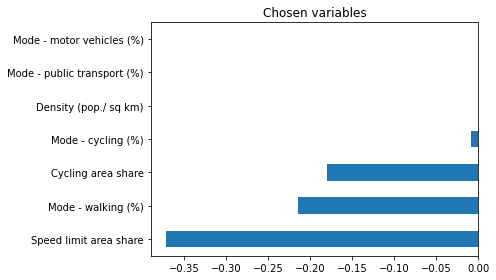

In [104]:
# showing the variables chosen by the best estimator

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (7, 4))
coef.plot(kind='barh', title = 'Chosen variables')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

In [105]:
# identifying chosen urban features

coef = pd.Series(lasso_best.coef_, list(X_columns))
coef = coef.to_frame().reset_index().rename(columns={0: 'Value', 'index': 'Coefficient'})
coef_in = (coef.Value != 0)
coef_list = (coef_in.index[coef_in] + 4).tolist()

In [106]:
# setting the input/output variables for the prediction

cols = data.iloc[:, coef_list].columns.tolist()
X = data.iloc[:, coef_list].values
y = y.values

In [107]:
# prediction with the selected variables and 3-fold cross-validation

results = prediction(X, y, folds=3)

============================ FOLD NUMBER 1 ===================================
TRAIN: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
TEST: [0 1 2 3 4 5 6 7]
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     3.585
Date:                Wed, 14 Apr 2021   Prob (F-statistic):             0.0418
Time:                        00:04:42   Log-Likelihood:                -16.487
No. Observations:                  16   AIC:                             42.97
Df Residuals:                      11   BIC:                             46.84
Df Model:                           4                                         
Covariance Type:            nonrobust             

### Final model Car/Taxi occ. - Itself casualties

In [108]:
# final model with selected variables

X = data.iloc[:, coef_list]
y = data.iloc[:, 16]

In [109]:
# final OLS regression

X = sm.add_constant(X)
final = sm.OLS(y, X).fit()
p = final.params
print(final.summary())

print('\n')
print('R2: ', final.rsquared)
print('Predicted values: ', final.predict())

                              OLS Regression Results                              
Dep. Variable:     Car/Taxi occ. - Itself   R-squared:                       0.563
Model:                                OLS   Adj. R-squared:                  0.471
Method:                     Least Squares   F-statistic:                     6.129
Date:                    Wed, 14 Apr 2021   Prob (F-statistic):            0.00242
Time:                            00:04:42   Log-Likelihood:                -24.111
No. Observations:                      24   AIC:                             58.22
Df Residuals:                          19   BIC:                             64.11
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [110]:
# inverse transformation of the data

y_pred_inversed = scalery.inverse_transform(final.fittedvalues)
y_pred_inversed

array([ 3.39257773, 22.51577538, 20.23385433,  8.42751938, 15.42847078,
       21.88697379, 19.55536387,  7.23979855, 19.9571022 ,  3.5437744 ,
        7.77598982, 13.2415401 , 26.40326138, 33.60563191, 10.74817256,
        4.53082185, 23.80544016, 31.22817936, 25.92113318,  4.44856891,
       21.38791341, 30.89695716, 33.72077595, 14.05440384])

In [111]:
# inverse transformation of the data

y_inversed = scalery.inverse_transform(y)
y_inversed

array([ 0.  , 13.65, 11.79,  8.59, 15.5 , 34.75, 31.57,  3.23, 14.71,
        5.49, 14.24, 10.43, 17.52, 33.51, 12.95, 13.5 , 17.56, 30.41,
       14.15, 12.22,  9.13, 48.07, 48.04,  2.94])

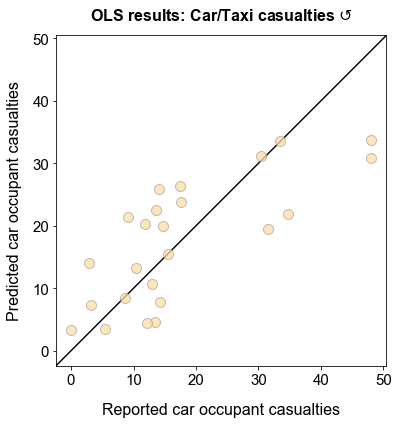

In [112]:
# showing the scatter plot

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(y_inversed, y_pred_inversed, marker= 'o', color= '#fedea3', s= 100, alpha= 0.75, edgecolors= '#A9A9A9')
ax.set_title(r"OLS results: Car/Taxi casualties $\circlearrowleft$", pad= 15, weight = 'bold', size=16, **afont)
ax.set_xlabel('Reported car occupant casualties', labelpad=15, size=16, **afont)
ax.set_ylabel('Predicted car occupant casualties', labelpad=10, size=16, **afont)
plt.xticks(fontsize=15, **afont)
plt.yticks(fontsize=15, **afont)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plotting the identity line
ax.plot(lims, lims, 'k-', alpha=0.95, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
#ax.grid(color='k', linestyle='-', linewidth=0.1)

# annotation of the cities
#for i, txt in enumerate(df_ped_car.City.tolist()):
#    plt.annotate(txt[:3], (y_inversed[i]-1, y_pred_inversed[i]+1.2), fontsize=15)

fig.tight_layout()
plt.show()

In [113]:
# showing the results as a table

results = pd.DataFrame([final.params, final.pvalues, final.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant', 1: cols[0], 2: cols[1], 3: cols[2], 4: cols[3]})#, 
                                                                                 #5: cols[4], 6: cols[5], 7: cols[6], 8: cols[7]})
conf_int = final.conf_int()
results['[0.025'] = conf_int.iloc[:,0]
results['0.975]'] = conf_int.iloc[:,1]
results

,parameters,p values,std,[0.025,0.975]
const,6.938894e-18,1.000000,0.151595,-0.317291,0.317291
Cycling area share,-2.170865e-01,0.261231,0.187474,-0.609474,0.175301
Speed limit area share,-4.367496e-01,0.016879,0.166751,-0.785763,-0.087737
Mode - walking (%),-2.878593e-01,0.114959,0.174246,-0.652560,0.076842
Mode - cycling (%),-8.835930e-02,0.620260,0.175419,-0.455517,0.278798


In [114]:
# preparing the final results table

#res.iloc[0,4] = 0
res.iloc[1,5] = results.iloc[1,0]
res.iloc[2,5] = results.iloc[2,0]
res.iloc[3,5] = results.iloc[3,0]
res.iloc[4,5] = results.iloc[4,0]
#res.iloc[5,4] = results.iloc[3,0]
res

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,PTW occ. - Car/Taxi,PTW occ. - Itself,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
Density (pop./ sq km),NaN,NaN,NaN,NaN,NaN,NaN
Cycling area share,-0.367784,NaN,NaN,NaN,-0.111731,-0.217086
Speed limit area share,NaN,0.261969,NaN,NaN,-0.167736,-0.43675
Mode - walking (%),-0.478856,-0.569935,NaN,NaN,-0.464173,-0.287859
Mode - cycling (%),-0.0976594,0.256337,NaN,-0.328664,-0.133155,-0.0883593
Mode - public transport (%),0.0869861,0.255617,NaN,NaN,0.0786049,NaN
Mode - motor vehicles (%),NaN,NaN,NaN,NaN,NaN,NaN


## **Creating a results heatmap**

In [115]:
# removing non-selected variables and powered-two wheeler-related pairs

res.drop(['Density (pop./ sq km)', 'Mode - motor vehicles (%)'], axis=0, inplace=True)
res.drop(['PTW occ. - Itself', 'PTW occ. - Car/Taxi'], axis=1, inplace=True)
res

,Pedestrian - Car/Taxi,Cyclist - Car/Taxi,Car/Taxi occ. - Car/Taxi,Car/Taxi occ. - Itself
Cycling area share,-0.367784,NaN,-0.111731,-0.217086
Speed limit area share,NaN,0.261969,-0.167736,-0.43675
Mode - walking (%),-0.478856,-0.569935,-0.464173,-0.287859
Mode - cycling (%),-0.0976594,0.256337,-0.133155,-0.0883593
Mode - public transport (%),0.0869861,0.255617,0.0786049,NaN


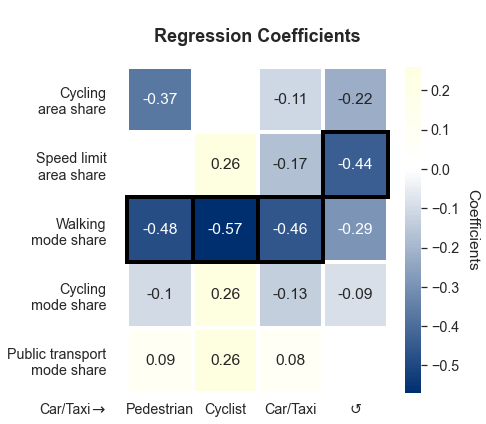

In [116]:
# showing the regression coefficients heatmap

cmap = LinearSegmentedColormap.from_list('mycmap', ['#002f70', 'white', '#fdffbd'])

fig = plt.figure(figsize=(6,6))
sns.set(font_scale=1.3)

with sns.axes_style("white"):
    hmap = sns.heatmap(res.values.astype(float).round(2), xticklabels= True, yticklabels=True,
                       square=True, center=0, #mask=res.isnull(), 
                       annot=True, linewidths=3, #annot_kws={"color": 'black'},
                       cmap=cmap)
hmap.set_xticklabels(labels= ['Pedestrian', 'Cyclist', 'Car/Taxi', '$\circlearrowleft$'], 
                     rotation= 0, ha="center", rotation_mode="anchor")
hmap.set_yticklabels(labels= ['Cycling\narea share', 'Speed limit\narea share', 'Walking\nmode share', 
                              'Cycling\nmode share', 'Public transport\nmode share'], 
                     rotation= 0, ha="right", rotation_mode="anchor")
hmap.tick_params(axis='y', which='major', pad=15)
hmap.collections[0].colorbar.set_label("Coefficients", rotation= -90, labelpad= 20)
plt.title('\nRegression Coefficients', loc='center', fontsize=18, weight='bold', pad=25)
plt.text(-1.35,5.32,'Car/Taxi', fontsize=14)
plt.text(-0.6,5.3,r'$\rightarrow$', fontsize=16)

hmap.add_patch(Rectangle((0, 2), 1, 1, fill=False, edgecolor='black', lw=4, clip_on=False))
hmap.add_patch(Rectangle((1, 2), 1, 1, fill=False, edgecolor='black', lw=4, clip_on=False))
hmap.add_patch(Rectangle((2, 2), 1, 1, fill=False, edgecolor='black', lw=4, clip_on=False))
hmap.add_patch(Rectangle((3, 1), 1, 1, fill=False, edgecolor='black', lw=4, clip_on=False))

plt.show()